<a href="https://colab.research.google.com/github/zack-murray/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")

diagnosis = df['diagnosis']

print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [117]:
df = df.drop(['diagnosis', 'Unnamed: 32'], axis=1)
df.head()


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [118]:
x = df.values

x

array([[8.4230200e+05, 1.7990000e+01, 1.0380000e+01, ..., 2.6540000e-01,
        4.6010000e-01, 1.1890000e-01],
       [8.4251700e+05, 2.0570000e+01, 1.7770000e+01, ..., 1.8600000e-01,
        2.7500000e-01, 8.9020000e-02],
       [8.4300903e+07, 1.9690000e+01, 2.1250000e+01, ..., 2.4300000e-01,
        3.6130000e-01, 8.7580000e-02],
       ...,
       [9.2695400e+05, 1.6600000e+01, 2.8080000e+01, ..., 1.4180000e-01,
        2.2180000e-01, 7.8200000e-02],
       [9.2724100e+05, 2.0600000e+01, 2.9330000e+01, ..., 2.6500000e-01,
        4.0870000e-01, 1.2400000e-01],
       [9.2751000e+04, 7.7600000e+00, 2.4540000e+01, ..., 0.0000000e+00,
        2.8710000e-01, 7.0390000e-02]])

In [119]:
# Perform KMeans clustering on the data
kmeans = KMeans(3)
# Find the clusters in the dataset
kmeans.fit(x)

print(kmeans.labels_)


[0 0 2 2 2 0 0 2 0 2 0 2 0 0 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 0 0
 0 0 0 2 2 2 2 0 0 2 2 2 0 2 2 0 0 2 2 0 0 2 0 0 0 0 2 0 0 2 0 0 0 0 2 0 0
 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 2 0 0 2 0 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 0 

In [120]:
# Add labels column to df 
df['labels'] = kmeans.labels_

df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,labels
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,2


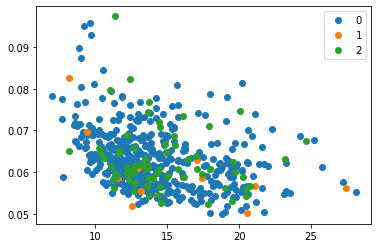

In [121]:
# Vizualizing and comparing
groups = df.groupby("labels")
for name, group in groups:
    plt.plot(group["radius_mean"], group["fractal_dimension_mean"], marker="o", linestyle="", label=name)
plt.legend()
plt.show()

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [122]:
# Add diagnosis column back 
df['diagnosis'] = diagnosis
# Make diagnosis column numeric
df = df.replace({'B': 0, 'M': 1})

df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,labels,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,2,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,2,1


In [123]:
# Find success rate
(df['labels'] == df['diagnosis']).value_counts()[0] / df.shape[0]

0.43936731107205623

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [124]:
X = df.drop(['labels','diagnosis'], axis=1).values

X

array([[8.4230200e+05, 1.7990000e+01, 1.0380000e+01, ..., 2.6540000e-01,
        4.6010000e-01, 1.1890000e-01],
       [8.4251700e+05, 2.0570000e+01, 1.7770000e+01, ..., 1.8600000e-01,
        2.7500000e-01, 8.9020000e-02],
       [8.4300903e+07, 1.9690000e+01, 2.1250000e+01, ..., 2.4300000e-01,
        3.6130000e-01, 8.7580000e-02],
       ...,
       [9.2695400e+05, 1.6600000e+01, 2.8080000e+01, ..., 1.4180000e-01,
        2.2180000e-01, 7.8200000e-02],
       [9.2724100e+05, 2.0600000e+01, 2.9330000e+01, ..., 2.6500000e-01,
        4.0870000e-01, 1.2400000e-01],
       [9.2751000e+04, 7.7600000e+00, 2.4540000e+01, ..., 0.0000000e+00,
        2.8710000e-01, 7.0390000e-02]])

In [125]:
# Instantiate "make a version of" a standard scaler object.
scaler = StandardScaler()
# Standardize
Z = scaler.fit_transform(X)

Z

array([[-0.23640517,  1.09706398, -2.07333501, ...,  2.29607613,
         2.75062224,  1.93701461],
       [-0.23640344,  1.82982061, -0.35363241, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 0.43174109,  1.57988811,  0.45618695, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [-0.23572747,  0.70228425,  2.0455738 , ...,  0.41406869,
        -1.10454895, -0.31840916],
       [-0.23572517,  1.83834103,  2.33645719, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-0.24240586, -1.80840125,  1.22179204, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [126]:
# Instantiate "make a version of" a PCA object.
pca = PCA(.9)
# Create our PCA dataset
pca_data = pca.fit_transform(Z)

pca_data

array([[ 9.18319983,  1.97127137, -1.17162471, ..., -1.37228049,
         0.37184363,  2.18052922],
       [ 2.38329766, -3.75345877, -0.58022866, ..., -0.12661612,
        -0.28826986,  0.04493484],
       [ 5.74247239, -1.08035048, -0.53308788, ..., -0.401855  ,
         0.4631876 , -0.7152086 ],
       ...,
       [ 1.2518901 , -1.89397674,  0.53446685, ...,  0.39471327,
        -0.43780583, -0.17866837],
       [10.36503528,  1.69639755, -1.90741785, ..., -0.65671962,
        -0.19526395,  0.27520221],
       [-5.47826365, -0.67278804,  1.47716504, ..., -1.57207609,
         0.60034041,  1.63559151]])

In [127]:
pca.explained_variance_[0] / np.sum(pca.explained_variance_)

0.4689605368471781

In [0]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

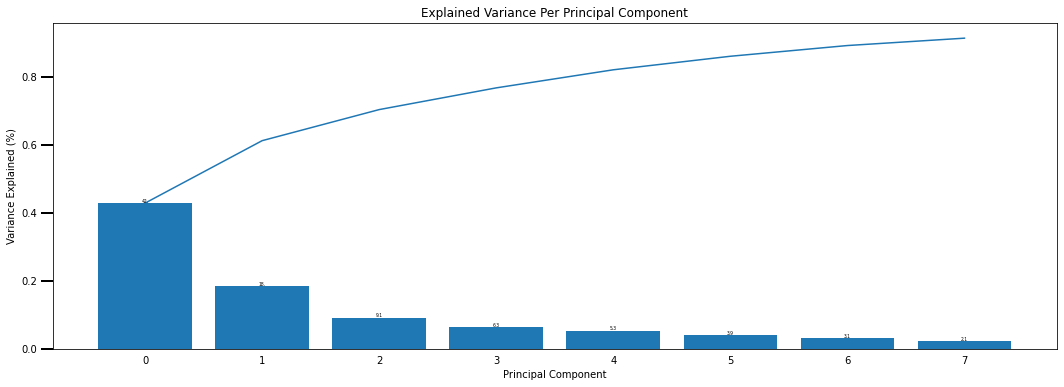

In [129]:
scree_plot(pca)

In [130]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(pca_data)

print(kmeans.labels_)

[1 1 1 2 1 2 1 2 2 2 0 2 1 0 2 2 0 2 1 0 0 0 2 1 1 1 2 1 2 1 1 2 1 1 2 2 2
 0 0 2 0 2 1 2 0 1 0 2 0 0 0 0 0 1 0 0 1 2 0 0 0 0 2 0 2 2 0 0 2 0 1 2 2 0
 0 1 0 1 1 0 0 2 1 1 0 1 0 1 0 2 0 0 0 0 2 1 0 0 0 2 0 0 0 0 0 2 0 0 1 0 0
 2 2 0 0 0 0 2 2 0 0 1 1 0 0 0 0 1 2 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 2 2 0
 0 0 0 2 2 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 2 0 0 0 2 2 0 0 1 1 0 0 0
 0 0 0 0 0 2 0 0 2 2 0 2 1 1 2 0 1 1 2 0 0 0 0 2 0 1 0 1 2 2 2 2 0 1 1 0 0
 0 2 0 0 0 0 0 2 2 0 0 1 0 0 1 1 0 1 0 0 2 0 1 0 0 2 0 0 1 0 1 0 1 0 1 2 1
 2 1 0 1 0 1 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 1 0 1 2 0 0 0 0 2 0 2 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 1 0 1 0 0 0 0 2 2 2 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 2 1 2 0 0 2 0 0 0 0 0 0 0 0 1 1 0 1 1
 2 0 1 1 0 0 2 0 0 2 0 0 0 2 0 0 0 0 2 1 0 0 2 1 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 2 0 1 1 0 2 0 0 0 0 2 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 2 0 0 1 2 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 2 0 1 0 0 0 0 1 

In [131]:
df['labels'] = kmeans.labels_

df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,labels,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,1


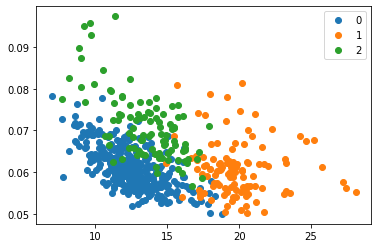

In [132]:
groups = df.groupby("labels")
for name, group in groups:
    plt.plot(group["radius_mean"], group["fractal_dimension_mean"], marker="o", linestyle="", label=name)
plt.legend()
plt.show()

In [133]:
(df['labels'] == df['diagnosis']).value_counts()[1] / df.shape[0]
# Huge success!

0.7574692442882249

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [135]:
# Create df to hold pca_data
pca_df = pd.DataFrame(pca_data)

pca_df.columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8']
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,9.183200,1.971271,-1.171625,3.639332,-1.193098,-1.372280,0.371844,2.180529
1,2.383298,-3.753459,-0.580229,1.127438,0.624850,-0.126616,-0.288270,0.044935
2,5.742472,-1.080350,-0.533088,0.903470,-0.180601,-0.401855,0.463188,-0.715209
3,7.124384,10.272225,-3.150161,0.121512,-2.968055,-2.561668,1.950177,1.287990
4,3.945694,-1.959689,1.401177,2.937555,0.540853,1.233300,-0.205435,-0.959329


In [136]:
# Add labels and diagnosis column to the new df 
pca_df['labels'] = kmeans.labels_
pca_df['diagnosis'] = diagnosis

pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,labels,diagnosis
0,9.183200,1.971271,-1.171625,3.639332,-1.193098,-1.372280,0.371844,2.180529,1,M
1,2.383298,-3.753459,-0.580229,1.127438,0.624850,-0.126616,-0.288270,0.044935,1,M
2,5.742472,-1.080350,-0.533088,0.903470,-0.180601,-0.401855,0.463188,-0.715209,1,M
3,7.124384,10.272225,-3.150161,0.121512,-2.968055,-2.561668,1.950177,1.287990,2,M
4,3.945694,-1.959689,1.401177,2.937555,0.540853,1.233300,-0.205435,-0.959329,1,M


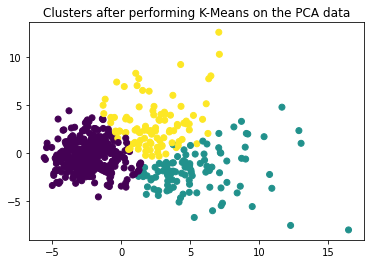

In [137]:
# Showing improved success rate  
plt.scatter(pca_df['pc1'], pca_df['pc2'], c=df['labels'])
plt.title("Clusters after performing K-Means on the PCA data")
plt.show()

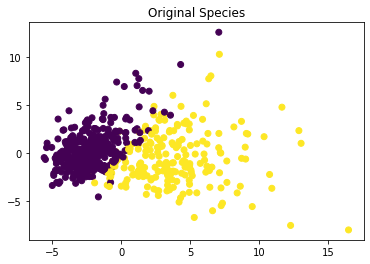

In [139]:
# Showing the original success rate
plt.scatter(pca_df['pc1'], pca_df['pc2'], c=df['diagnosis'])
plt.title("Original Diagnosis")
plt.show()

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project